# Graph Neural Network test teacher

## Importing

In [1]:
import sys
sys.path.append('../')

In [2]:
from selfdist_toolkit.pyg_tools import gnn_load, GIN_nn, execution, sd_utils, accuracy, early_stopping
import pandas as pd
import torch
import torch_geometric
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

C:\Users\johan\anaconda3\envs\praktikum\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data loading (aid list)

In [3]:
aid_list = pd.read_csv("../results/random_forest/experiments_check/chem-desc_good-aid_1.csv").aid.to_numpy().astype(int)

In [4]:
aid_list

array([    884,     891,     899,     914,    1418,    1431,    1770,
          1771,    1795,  493073,  493102,  493177,  493191,  493240,
        588834,  651741,  651812,  651814,  686978,  687022,  720691,
        743036,  743040,  743065, 1053173, 1259381, 1346982])

## Data loading (all molecules for self distillation)

In [5]:
# get list of all molecules as pyg elements
all_molec_list = gnn_load.load_all_pyg(path_data="../data/")

In [6]:
# load all the smiles as string list
all_smiles = np.array([mol.smiles for mol in all_molec_list], dtype=str)

## Procedure environment setting

In [7]:
# number epochs
epochs = 300

In [8]:
# random state where we want to set it
random_state = 131313

In [9]:
# hard mode - soft mode is actually deprecated
mode = "hard"

In [10]:
# batch size
batch_size=100

## Setting up storage location

In [11]:
# path for csv dataframe
csv_path = "../results/teacher_exp_es/csv/"
# path for graphs
graphs_path = "../results/teacher_exp_es/graphs/"
# path for self distillation output
sd_path = "../results/teacher_exp_es/sd_out/"

In [12]:
# make sure the folder exists
if not os.path.exists(csv_path):
    os.makedirs(csv_path)
if not os.path.exists(graphs_path):
    os.makedirs(graphs_path)
if not os.path.exists(sd_path):
    os.makedirs(sd_path)

## Iteration over assay ids and execution of procedure

In [16]:
forbidden_aid=[686978]

In [19]:
for i, aid in enumerate(aid_list):
    
    # =================================================
    # Progress output
    # =================================================
    # print actual state
    print("current aid: {}, {}/{} - {:2.2%}".format(
        aid,
        i,
        aid_list.shape[0],
        i/aid_list.shape[0]
    ))
    
    # if experiment in forbidden experiments skip it
    if aid in forbidden_aid:
        print("skipped because in forbidden list")
        continue
    
    # =================================================
    # Load data
    # =================================================
    # load data for experiment
    whole_data = gnn_load.load_pyg_data_aid(aid=aid, label_type=mode, do_in_parallel=True, path_data="../data/")
    
    # get hard labels
    labels_hard = np.array([
        data.y.detach().cpu().numpy()
        for data in whole_data
    ]).flatten().astype(int)
    
    # do data splitting in train and test 80:20
    # data splitting
    for train_idx, test_idx in StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2).split(whole_data, labels_hard):
        break
        
    # temporarily reindex data for another split
    temp_data = [whole_data[idx] for idx in train_idx]
    temp_label = [labels_hard[idx] for idx in train_idx]
    
    # resplit data
    for train_idx, val_idx in StratifiedShuffleSplit(n_splits=1, random_state=random_state+7, test_size=0.125).split(temp_data, temp_label):
        break
    
    # generate the dataloader
    dl_train = torch_geometric.loader.DataLoader([temp_data[idx] for idx in train_idx], batch_size=batch_size)
    dl_val = torch_geometric.loader.DataLoader([temp_data[idx] for idx in val_idx], batch_size=batch_size)
    dl_test = torch_geometric.loader.DataLoader([whole_data[idx] for idx in test_idx], batch_size=batch_size)
    
    # =================================================
    # Model setup
    # =================================================
    # GNN model
    model = GIN_nn.GIN_basic(1)
    # loss
    loss = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([len(train_idx)/labels_hard[train_idx].sum()]))
    # device
    device = torch.device('cuda')
    model = model.to(device)
    loss = loss.to(device)
    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # =================================================
    # Epoch iteration
    # =================================================
    # define loss saving space
    loss_storage = []
    
    # define accuracy storage
    accuracy_storage = []
    
    # initialize early stopping
    es = early_stopping.EarlyStopBasic(min_improvement=0, measurement="roc_score", num_epoch_wait=7)
    
    # epoch iterations
    for epoch in tqdm(range(epochs)):
        
        # do training step
        loss_value = execution.training(model, dl_train, device, optimizer, loss, verbose=False)

        # put loss into storage
        loss_storage.append(loss_value)

        # do testing step
        y_pred_hard = execution.predict(model, dl_test, device, reduce_to_hard_label=True, verbose=False)

        # calculate accuracy DataFrame
        accuracy_storage.append(
            # get accuracy class and from it the DataFrame
            accuracy.calculate_accuracies_1d(
                y_pred=y_pred_hard, 
                y_true=accuracy.helper_pyg_to_numpy_label(
                    data_loader=dl_test
                )
            ).to_df(index=epoch)
        )
        
        # determine whether to stop training or not
        if es.new_epoch_test_stop(
            
            # calculate accuracy for validation set
            accuracy.calculate_accuracies_1d(
                y_pred=execution.predict(model, dl_val, device, reduce_to_hard_label=True, verbose=False),
                y_true=accuracy.helper_pyg_to_numpy_label(data_loader=dl_val)
            )
            
        ):
            # print message that early stopping is required and beak for loop
            print("Early stopping mechanism triggered - stopped training after epoch {}.".format(epoch))
            break
    
    # transform accuracy storage to pandas df
    accuracy_storage = pd.concat(accuracy_storage)

    # add new column for loss
    accuracy_storage['loss'] = loss_storage
    
    # =================================================
    # Save data to file
    # =================================================
    # set file path
    file_path = csv_path + "teacher-acc_aid={}_epochs={}.csv".format(aid, epochs)
    
    # write to file
    accuracy_storage.to_csv(file_path, index=True, index_label="epoch")
    
    # =================================================
    # Self distillation calculate accuracy of all other molecules
    # =================================================
    # get the aid smiles
    aid_smiles = gnn_load.load_pure_data(aid, path_data="../data/").smiles.to_numpy().astype(str)
    
    # get index of elements where the elements are not the same (new elements)
    idx = np.where(np.invert(np.in1d(all_smiles, aid_smiles)))[0].tolist()
    
    # get the items which are new
    molec_list = list(map(all_molec_list.__getitem__, idx))
    dl_sd = torch_geometric.loader.DataLoader(molec_list, batch_size=batch_size)
    
    # get prediction
    sd_pred = execution.predict(model, dl_sd, device, reduce_to_hard_label=False, verbose=True)
    
    # create Dataframe and save it
    sd_file_path = sd_path + "teacher-pred_aid={}_epochs={}.csv".format(aid, epochs)
    pd.DataFrame({
        "smiles": list(map(lambda x: x.smiles, molec_list)),
        "predicted_label_soft": sd_pred
    }).to_csv(sd_file_path, index=False)

current aid: 884, 0/27 - 0.00%


  5%|████████████▋                                                                                                                                                                                                                                                                    | 14/300 [00:40<13:50,  2.90s/it]

Early stopping mechanism triggered - stopped training after epoch 14.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4455/4455 [00:56<00:00, 78.83it/s]


current aid: 891, 1/27 - 3.70%


  3%|█████████                                                                                                                                                                                                                                                                        | 10/300 [00:25<12:12,  2.53s/it]

Early stopping mechanism triggered - stopped training after epoch 10.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4477/4477 [00:56<00:00, 79.28it/s]


current aid: 899, 2/27 - 7.41%


  3%|█████████                                                                                                                                                                                                                                                                        | 10/300 [00:25<12:18,  2.55s/it]

Early stopping mechanism triggered - stopped training after epoch 10.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4473/4473 [00:56<00:00, 78.73it/s]


current aid: 914, 3/27 - 11.11%


  8%|█████████████████████▊                                                                                                                                                                                                                                                           | 24/300 [00:51<09:52,  2.15s/it]

Early stopping mechanism triggered - stopped training after epoch 24.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4478/4478 [00:57<00:00, 77.90it/s]


current aid: 1418, 4/27 - 14.81%


  6%|████████████████▍                                                                                                                                                                                                                                                                | 18/300 [00:06<01:42,  2.74it/s]

Early stopping mechanism triggered - stopped training after epoch 18.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:58<00:00, 78.18it/s]


current aid: 1431, 5/27 - 18.52%


  3%|████████▏                                                                                                                                                                                                                                                                         | 9/300 [00:04<02:23,  2.03it/s]

Early stopping mechanism triggered - stopped training after epoch 9.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4539/4539 [00:58<00:00, 78.24it/s]


current aid: 1770, 6/27 - 22.22%


  8%|█████████████████████▊                                                                                                                                                                                                                                                           | 24/300 [00:09<01:44,  2.63it/s]

Early stopping mechanism triggered - stopped training after epoch 24.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:58<00:00, 77.62it/s]


current aid: 1771, 7/27 - 25.93%


  5%|█████████████▋                                                                                                                                                                                                                                                                   | 15/300 [00:06<01:56,  2.45it/s]

Early stopping mechanism triggered - stopped training after epoch 15.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:58<00:00, 77.67it/s]


current aid: 1795, 8/27 - 29.63%


  8%|█████████████████████▊                                                                                                                                                                                                                                                           | 24/300 [00:09<01:47,  2.58it/s]

Early stopping mechanism triggered - stopped training after epoch 24.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:58<00:00, 78.00it/s]


current aid: 493073, 9/27 - 33.33%


  5%|██████████████▌                                                                                                                                                                                                                                                                  | 16/300 [00:05<01:42,  2.77it/s]

Early stopping mechanism triggered - stopped training after epoch 16.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:58<00:00, 77.43it/s]


current aid: 493102, 10/27 - 37.04%


  8%|████████████████████▉                                                                                                                                                                                                                                                            | 23/300 [00:08<01:41,  2.73it/s]

Early stopping mechanism triggered - stopped training after epoch 23.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:58<00:00, 78.04it/s]


current aid: 493177, 11/27 - 40.74%


 15%|█████████████████████████████████████████▊                                                                                                                                                                                                                                       | 46/300 [00:16<01:30,  2.81it/s]

Early stopping mechanism triggered - stopped training after epoch 46.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:58<00:00, 77.96it/s]


current aid: 493191, 12/27 - 44.44%


  7%|██████████████████▏                                                                                                                                                                                                                                                              | 20/300 [00:07<01:40,  2.78it/s]

Early stopping mechanism triggered - stopped training after epoch 20.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:58<00:00, 77.87it/s]


current aid: 493240, 13/27 - 48.15%


  8%|████████████████████▉                                                                                                                                                                                                                                                            | 23/300 [00:08<01:39,  2.79it/s]

Early stopping mechanism triggered - stopped training after epoch 23.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:56<00:00, 79.72it/s]


current aid: 588834, 14/27 - 51.85%


  5%|█████████████▋                                                                                                                                                                                                                                                                   | 15/300 [00:13<04:13,  1.12it/s]

Early stopping mechanism triggered - stopped training after epoch 15.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4520/4520 [00:56<00:00, 79.65it/s]


current aid: 651741, 15/27 - 55.56%


  4%|███████████▊                                                                                                                                                                                                                                                                     | 13/300 [00:04<01:36,  2.96it/s]

Early stopping mechanism triggered - stopped training after epoch 13.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4538/4538 [00:57<00:00, 79.04it/s]


current aid: 651812, 16/27 - 59.26%


  4%|███████████▊                                                                                                                                                                                                                                                                     | 13/300 [00:07<02:43,  1.75it/s]

Early stopping mechanism triggered - stopped training after epoch 13.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4534/4534 [00:56<00:00, 79.89it/s]


current aid: 651814, 17/27 - 62.96%


  6%|█████████████████▎                                                                                                                                                                                                                                                               | 19/300 [00:07<01:47,  2.62it/s]

Early stopping mechanism triggered - stopped training after epoch 19.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4540/4540 [00:56<00:00, 79.81it/s]


current aid: 686978, 18/27 - 66.67%
skipped because in forbidden list
current aid: 687022, 19/27 - 70.37%


  6%|█████████████████▎                                                                                                                                                                                                                                                               | 19/300 [00:06<01:38,  2.87it/s]

Early stopping mechanism triggered - stopped training after epoch 19.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4541/4541 [00:56<00:00, 79.76it/s]


current aid: 720691, 20/27 - 74.07%


  6%|███████████████▍                                                                                                                                                                                                                                                                 | 17/300 [00:26<07:20,  1.56s/it]

Early stopping mechanism triggered - stopped training after epoch 17.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4493/4493 [00:56<00:00, 79.35it/s]


current aid: 743036, 21/27 - 77.78%


  2%|██████▍                                                                                                                                                                                                                                                                           | 7/300 [00:10<07:38,  1.57s/it]

Early stopping mechanism triggered - stopped training after epoch 7.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4497/4497 [00:56<00:00, 80.27it/s]


current aid: 743040, 22/27 - 81.48%


  7%|████████████████████                                                                                                                                                                                                                                                             | 22/300 [00:40<08:25,  1.82s/it]

Early stopping mechanism triggered - stopped training after epoch 22.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4489/4489 [00:57<00:00, 78.24it/s]


current aid: 743065, 23/27 - 85.19%


  7%|███████████████████                                                                                                                                                                                                                                                              | 21/300 [00:29<06:38,  1.43s/it]

Early stopping mechanism triggered - stopped training after epoch 21.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4493/4493 [00:56<00:00, 80.11it/s]


current aid: 1053173, 24/27 - 88.89%


  4%|███████████▊                                                                                                                                                                                                                                                                     | 13/300 [00:06<02:15,  2.12it/s]

Early stopping mechanism triggered - stopped training after epoch 13.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4537/4537 [00:57<00:00, 79.52it/s]


current aid: 1259381, 25/27 - 92.59%


  3%|███████▎                                                                                                                                                                                                                                                                          | 8/300 [00:14<08:40,  1.78s/it]

Early stopping mechanism triggered - stopped training after epoch 8.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4490/4490 [00:57<00:00, 78.58it/s]


current aid: 1346982, 26/27 - 96.30%


  5%|██████████████▌                                                                                                                                                                                                                                                                  | 16/300 [00:25<07:25,  1.57s/it]

Early stopping mechanism triggered - stopped training after epoch 16.



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4495/4495 [00:55<00:00, 80.62it/s]


## Generate the graphs

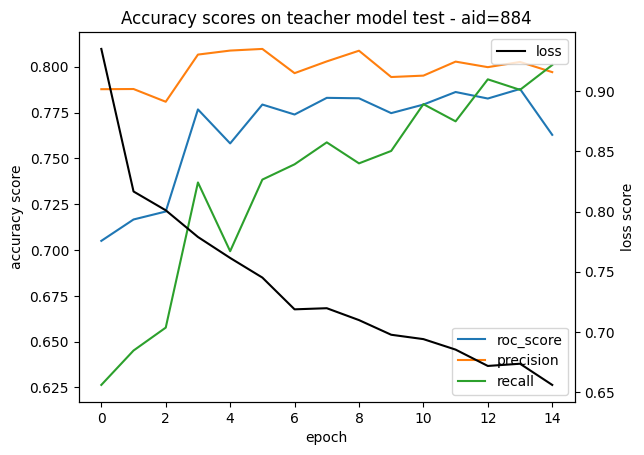

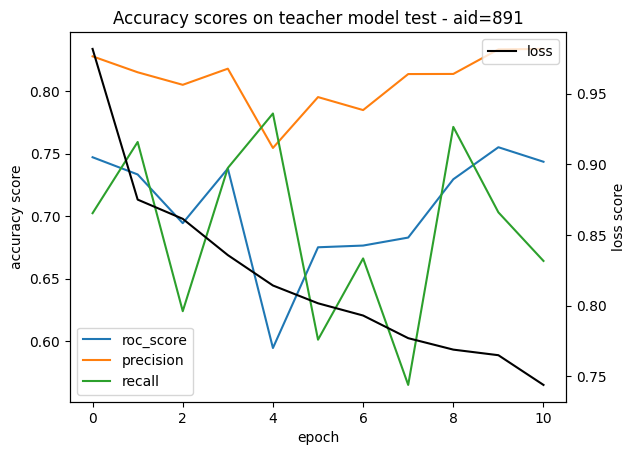

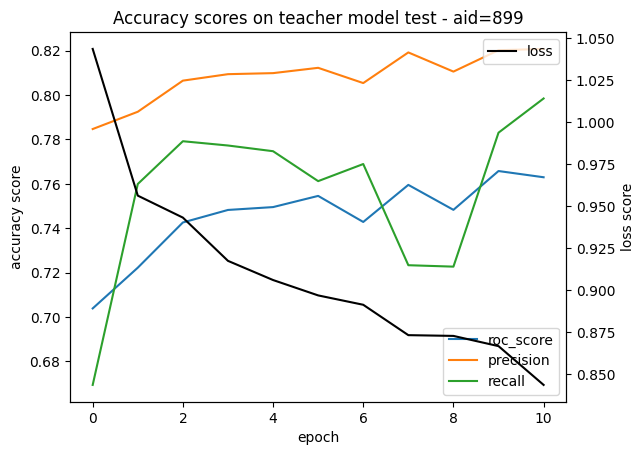

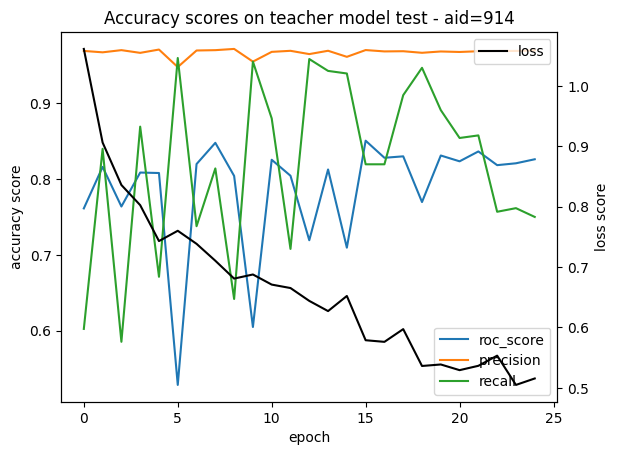

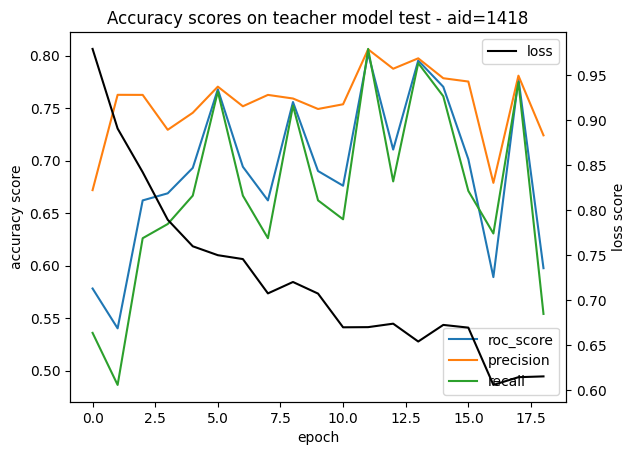

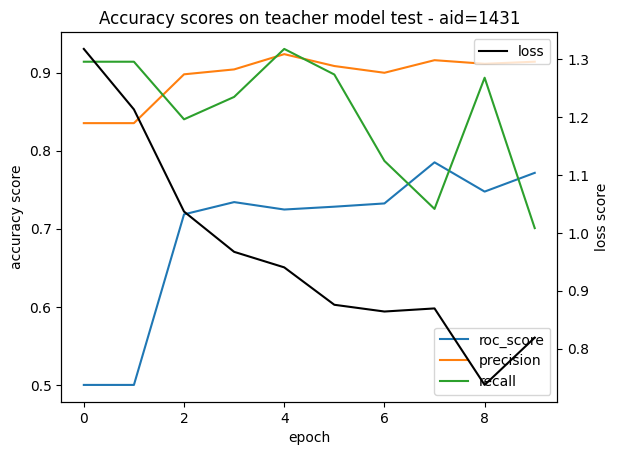

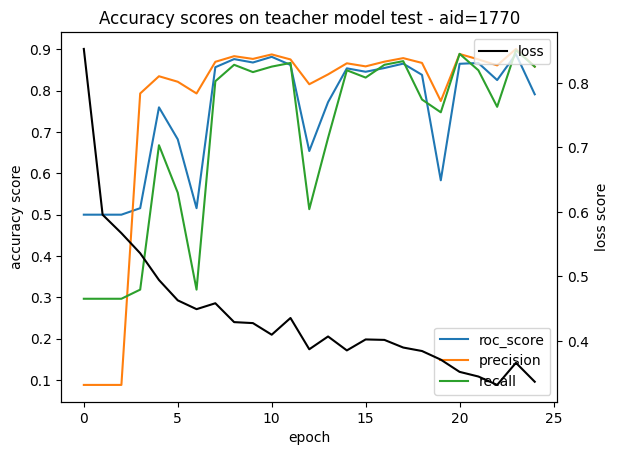

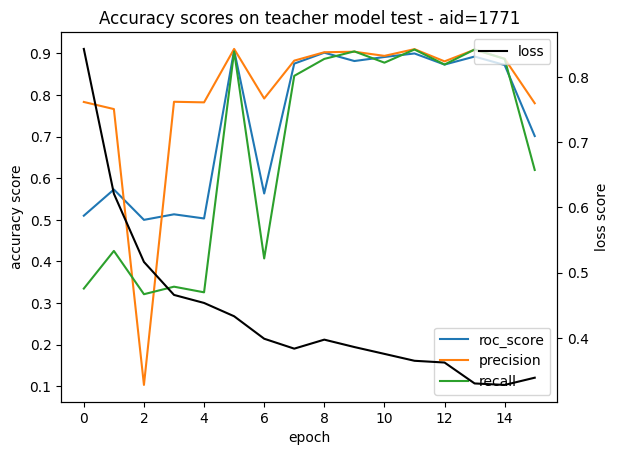

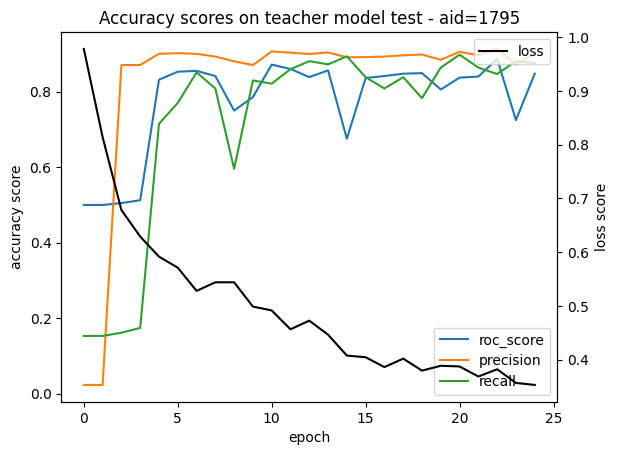

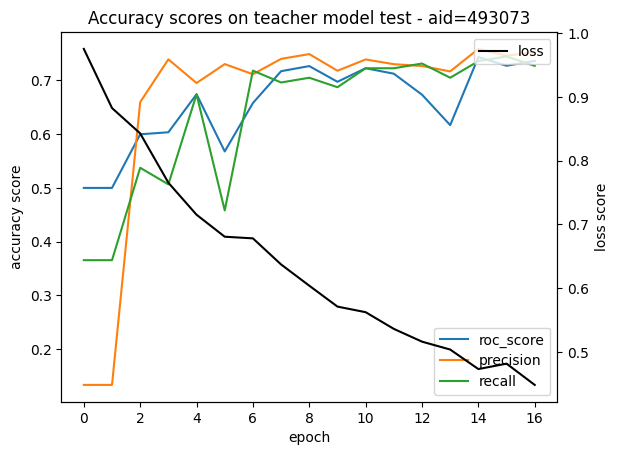

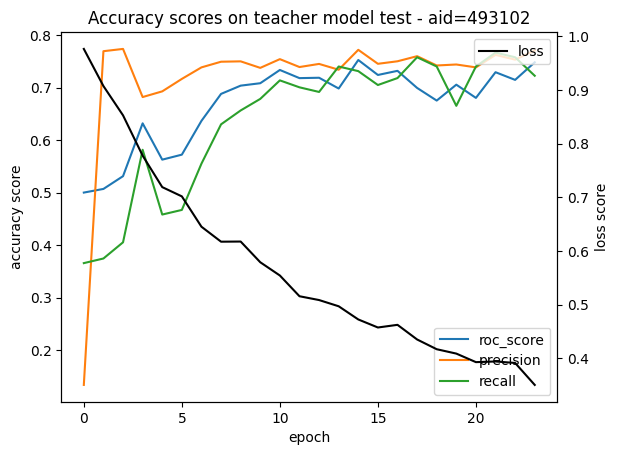

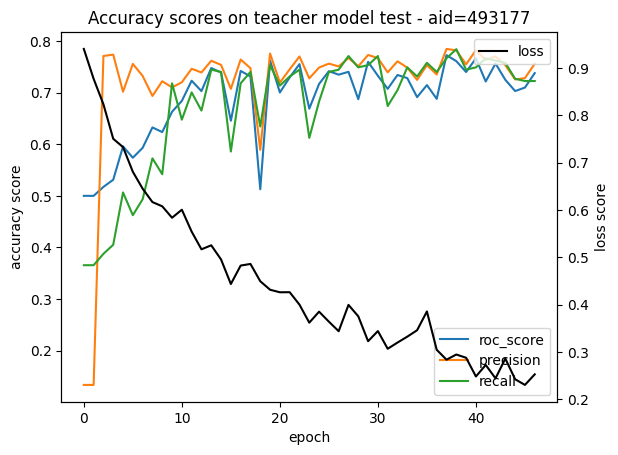

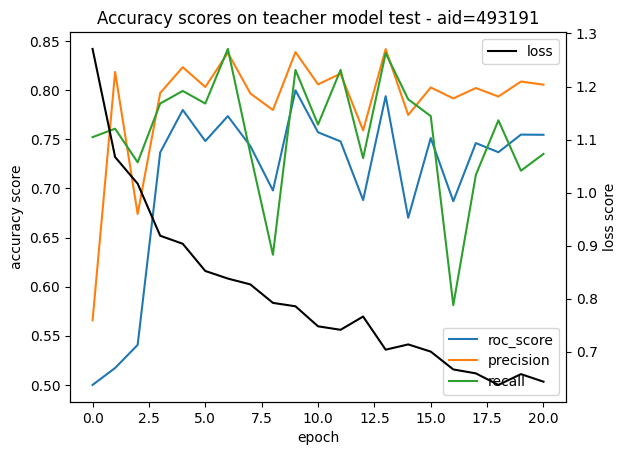

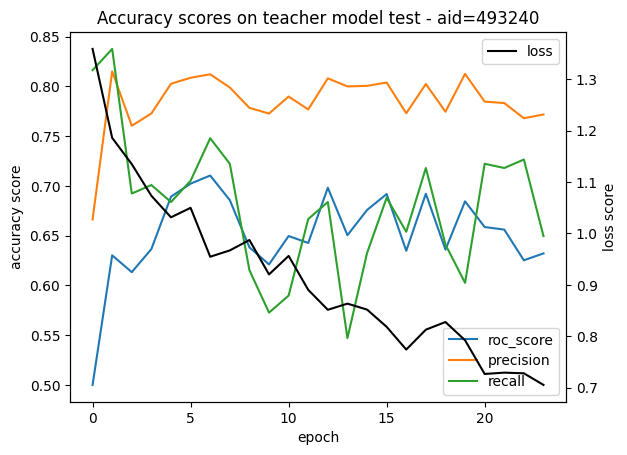

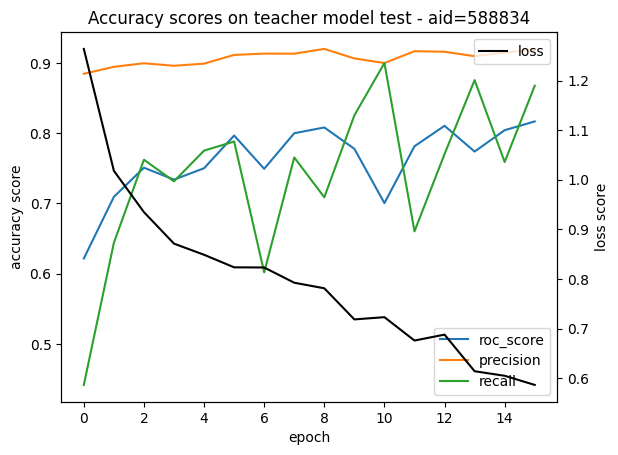

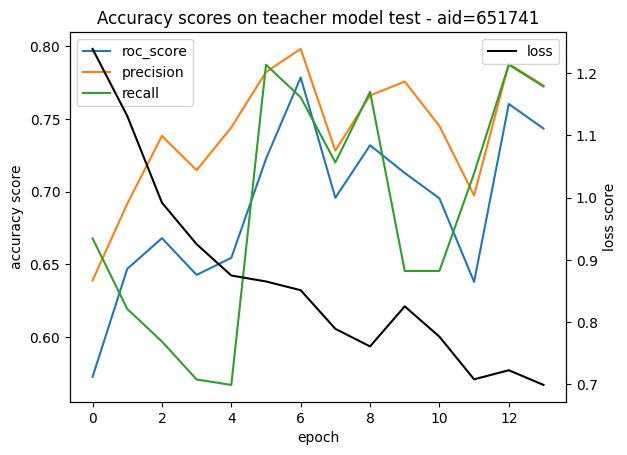

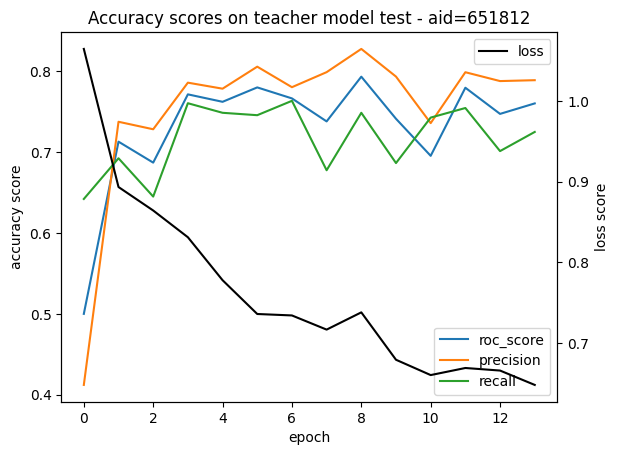

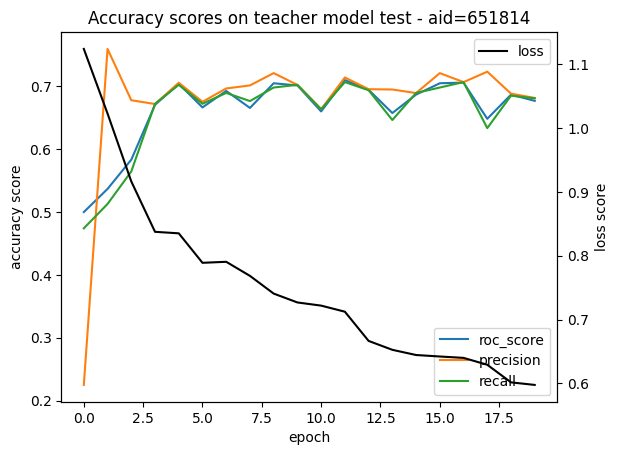

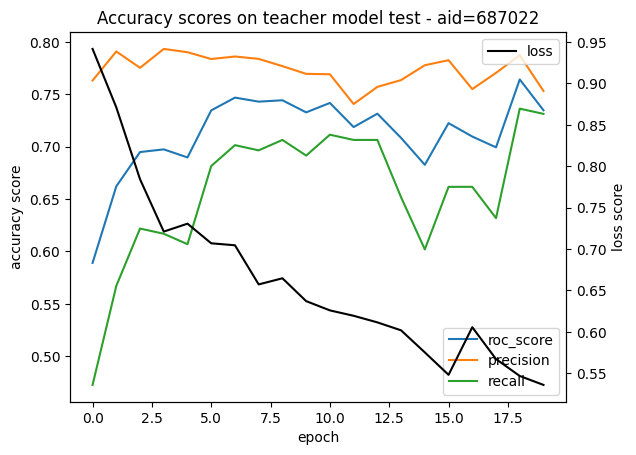

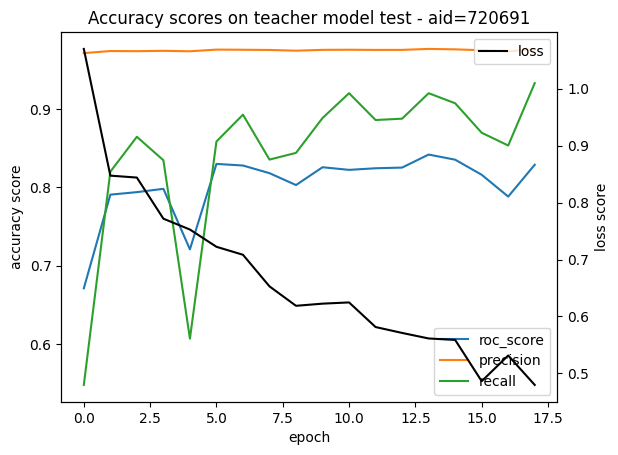

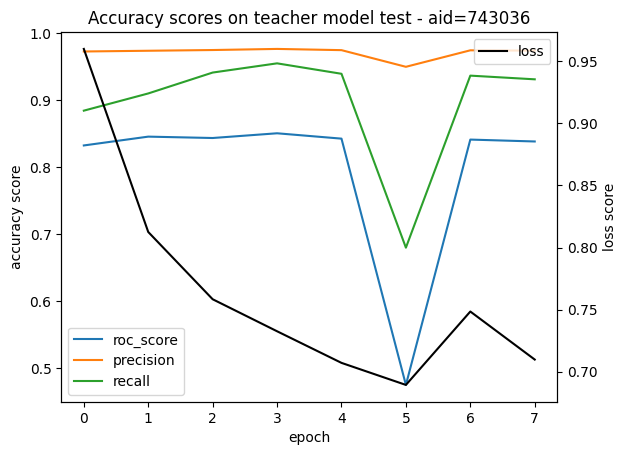

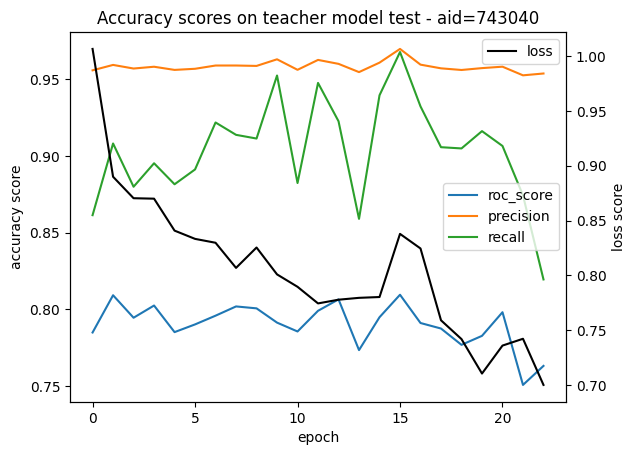

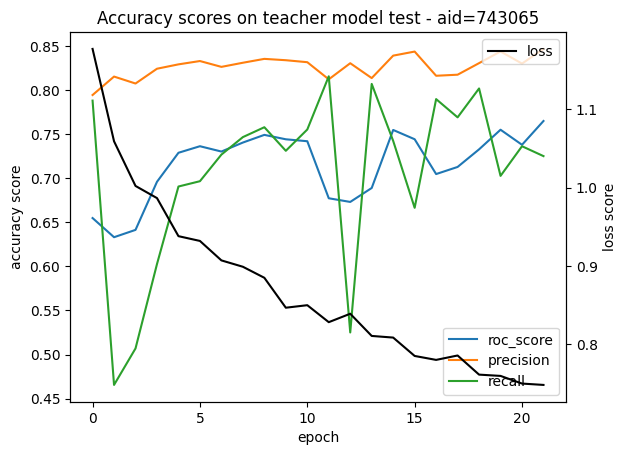

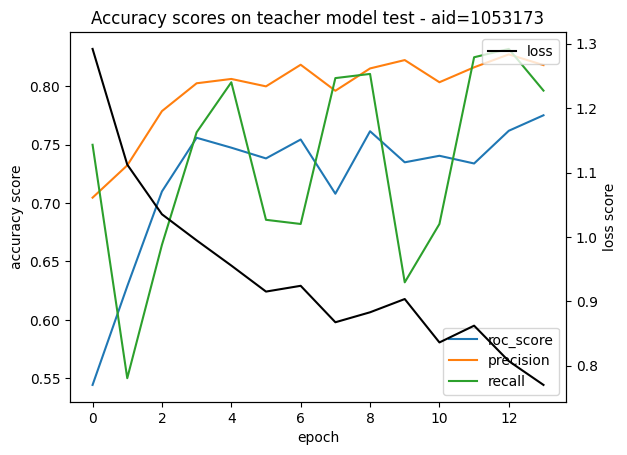

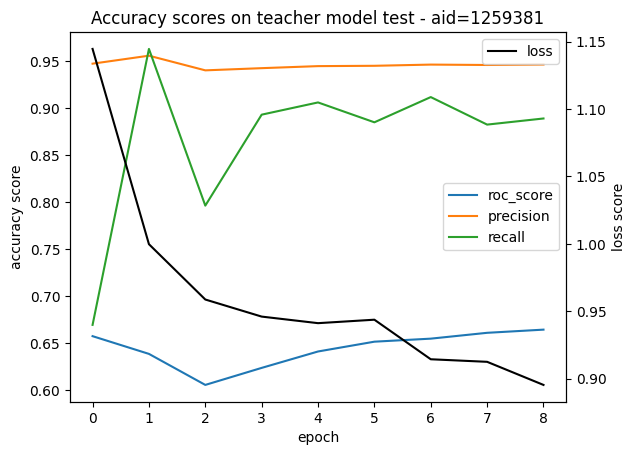

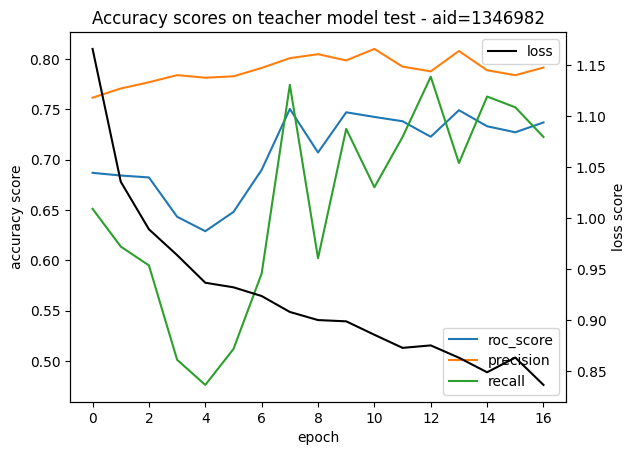

In [20]:
for aid in aid_list:
    
    # if experiment in forbidden experiments skip it
    if aid in forbidden_aid:
        continue
    
    # determine storage location of csv
    file_path = csv_path + "teacher-acc_aid={}_epochs={}.csv".format(aid, epochs)
    
    # determine storage location of image
    file_path_plot = graphs_path + "TeacherAccs_aid-{}_epochs-{}.png".format(aid, epochs)
    
    # load the csv
    loaded_csv = pd.read_csv(file_path, index_col="epoch")
    
    # plotting
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(loaded_csv.roc_score, label="roc_score")
    ax1.plot(loaded_csv.precision, label="precision")
    ax1.plot(loaded_csv.recall, label="recall")
    ax2.plot(loaded_csv.loss, color="black", label="loss")
    
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("accuracy score")
    ax2.set_ylabel("loss score")
    ax1.legend()
    ax2.legend()
    plt.title("Accuracy scores on teacher model test - aid={}".format(aid))
    plt.savefig(file_path_plot, bbox_inches='tight')
    plt.show()